In [1]:
from scripts import support, metrics, vectorization as v, aggregation
from scripts.kuroda import kuroda
from scripts.insd import insd
from scripts.nras import nras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
from scipy.sparse import csr_matrix
%matplotlib inline

# Препроцессинг

## Агрегирование

### 1. Таблица ресурсов за 2011 год

Загружаем базовую таблицу ресурсов за 2011 год.

In [2]:
# базовая таблица РЕСУРСОВ за 2011

df = pd.read_excel("./data/baz2011.xlsx", "ТР")
df = df.iloc[1:-3,3:-7]
df = df.fillna(0)

base2011_codes = df.drop(df.index[[1]], axis=0) # таблица 2011 года с кодами
base2011 = df.drop(df.index[[0,1]], axis=0) # таблица 2011 года без кодов

show_base2011_codes = base2011_codes # сохранили, чтобы была возможность в любой момент посмотреть таблицу
show_base2011 = base2011

print('Размер базовой таблицы ресурсов за 2011 год: ', base2011.shape)

base2011 = np.array(df.drop(df.index[[0,1]], axis=0))
base2011 = v.tovector(base2011).astype(float) # векторизовали


Размер базовой таблицы ресурсов за 2011 год:  (248, 178)


#### Агрегирование по отраслям (столбцы)

Поскольку степени агрегации для 2011 и 2016 годов различны, сделаем единую систему: будем объединять все отрасли с одинаковым начальным номером (проверяем первые две цифры), суммируя внутренние значения. 

In [3]:
# в строке с кодами оставим только первые два символа -- по ним и будем объединять

for i in range(178):
    a = str(base2011_codes.ix[1][i])
    a = a[:2]
    base2011_codes.ix[1][i] = a
    
base2011_codes.columns = base2011_codes.iloc[0] # сделали преобразованную строку с кодами -- заголовками
base2011_codes = base2011_codes.drop(base2011_codes.index[0]) # избавились от отдельной строки с кодами

base2011_codes = base2011_codes.groupby(base2011_codes.columns, axis=1).sum() # объединили данные в таблице по одинаковым столбцам
                                                                              # (внутри суммируем)

#### Агрегирование по продуктам (строки)

In [4]:
# создаем функцию, которая будет отрезать первые две цифры кода продукта
def splitter(x):    
    a = str(x)
    a=a[:2]
    return a

df = pd.read_excel("./data/baz2011.xlsx", "ТР") # считали столбец с кодами
df = df.iloc[3:-3,1:2]
df = df.fillna(0)
base2011_codes['codes_prod'] = df

base2011_codes['codes_prod'] = base2011_codes['codes_prod'].apply(lambda x: splitter(x))  # преобразовали все коды до двух цифр
base2011_codes = base2011_codes.groupby(base2011_codes['codes_prod']).sum() # сгруппировали

#### Векторизация

In [27]:
ag2011 = base2011_codes

ag2011_arr = np.array(base2011_codes)
ag2011_vec = v.tovector(ag2011_arr).astype(float)

### 2. Таблица ресурсов за 2016 год

In [6]:
# базовая таблица РЕСУРСОВ за 2016

df = pd.read_excel("./data/baz2016.xlsx", "ТР ")
df = df.iloc[1:-3,3:-7]
df = df.fillna(0)

base2016_codes = df.drop(df.index[[1]], axis=0) # таблица 2011 года с кодами
base2016 = df.drop(df.index[[0,1]], axis=0) # таблица 2011 года без кодов

show_base2016_codes = base2016_codes # сохранили, чтобы была возможность в любой момент посмотреть таблицу
show_base2016 = base2016

print('Размер базовой таблицы ресурсов за 2011 год: ', base2016.shape)

base2016 = np.array(df.drop(df.index[[0,1]], axis=0))
base2016 = v.tovector(base2011).astype(float) # векторизовали

Размер базовой таблицы ресурсов за 2011 год:  (206, 98)


#### Агрегирование по отраслям (столбцы)

In [7]:
for i in range(98):
    a = str(base2016_codes.ix[1][i])
    a = a[:2]
    base2016_codes.ix[1][i] = a
    
base2016_codes.columns = base2016_codes.iloc[0] # сделали преобразованную строку с кодами -- заголовками
base2016_codes = base2016_codes.drop(base2016_codes.index[0]) # избавились от отдельной строки с кодами

base2016_codes = base2016_codes.groupby(base2016_codes.columns, axis=1).sum() # объединили данные в таблице по одинаковым столбцам
                                                                              # (внутри суммируем)

#### Агрегирование по продуктам (строки)

In [8]:
df = pd.read_excel("./data/baz2016.xlsx", "ТР ") # считали столбец с кодами
df = df.iloc[3:-3,1:2]
df = df.fillna(0)
base2016_codes['codes_prod'] = df

base2016_codes['codes_prod'] = base2016_codes['codes_prod'].apply(lambda x: splitter(x))  # преобразовали все коды до двух цифр
base2016_codes = base2016_codes.groupby(base2016_codes['codes_prod']).sum() # сгруппировали

In [25]:
base2016_codes.shape

(59, 59)

In [26]:
ag2016 = base2016_codes

ag2016_arr = np.array(base2016_codes)
ag2016_vec = v.tovector(ag2016_arr).astype(float)

In [ ]:
experiments('sum', 'base2011_codes', 'base2016_codes', 'base2016_codes', 'проекция')

#### Проверка

In [11]:
df = pd.read_excel("./data/tri-2011 .xls", "ТР")
df = df.iloc[3:-3,3:-6]
df = df.fillna(0)

new_2011 = df

In [28]:
((np.array(ag2011)-np.array(new_2011))**2).sum()

0.0

### Работаем с двумя таблицами

In [13]:
# Занулим элементы, в которых меняется знак

ag2011[ag2011 * ag2016 < 0] = 0
ag2016[ag2011 * ag2016 < 0] = 0

In [29]:
# Считаем итоги по строкам и столбцам

# Для 2011 года:
rows_sums_2011 = np.sum(ag2011, axis=1)
columns_sums_2011 = np.sum(ag2011, axis=0)
totals_2011 = np.concatenate((rows_sums_2011, columns_sums_2011)).astype(float)[np.newaxis].T

# Для 2016 года:
rows_sums_2016 = np.sum(ag2016, axis=1)
columns_sums_2016 = np.sum(ag2016, axis=0)
totals_2016 = np.concatenate((rows_sums_2016, columns_sums_2016)).astype(float)[np.newaxis].T

In [34]:
totals_2011.shape

(118, 1)

## Проекция

In [43]:
##### from scripts import support, metrics, vectorization as v, aggregation
def experiment(tables_kind, method_name, bench_matrix, origin_matrix, target_matrix, experiment_type, sparsed = True, save = True, totals = False):
    """
    Получение результата эксперимента

    Parameters
    ----------
    tables_kind: string
        степень аггрегации таблиц
    method_name: string
        метод для получения новой матрицы
    bench_matrix: np.array или sparse матрица
        бенчмарк таблица
    origin_matrix: np.array или sparse матрица
        оригинальная таблица
    target_matrix: np.array или sparse матрица
        целевая таблица
    experiment_type: string
        агрегация\дезаггрегация\проекция
    sparse: bool
        использовать sparse матрицу или np.array
    Returns
    -------
    a: float
        значение метрики
    """
    if experiment_type == 'дезаггрегация':
        if tables_kind == 'sum':
            g = aggregation.keys_to_g(left_sum, right_sum)
        elif tables_kind == 'sect':
            g = aggregation.keys_to_g(left_sect, right_sect)
        else:
            raise Exception("Wrong tables_kind", tables_kind)
    elif experiment_type == 'проекция':
        ttls = v.addrows((59,59))
        g = v.addcolumns((59,59), ttls)
    else:
        raise Exception("Wrong experiment_type",experiment_type)  
    

    if sparsed:
        g = csr_matrix(g)
        
    if totals:
        g_w_totals = v.addrows((59,59), g, sparsed=sparsed)
        g_w_totals = v.addcolumns((59,59), g_w_totals, sparsed=sparsed)
    
    # For Kuroda
    if len(method_name.split('_')) > 1:
        
        method, mtype = method_name.split('_')
        method = eval(method)
        results = np.round(method(g, eval(bench_matrix), eval(origin_matrix), mtype=int(mtype), sparsed=sparsed))
    else:
        method = eval(method_name)
        results = method(g, eval(bench_matrix), eval(origin_matrix), sparsed=sparsed)
    metrics_values = metrics.get_values(np.round(results), eval(target_matrix), save=True)
    
    # Save metrics' results
    if save:
        info = {'method':method_name, 'experiment_type':experiment_type, 'target_matrix':target_matrix, 
                'origin_matrix':origin_matrix, 'bench_matrix':bench_matrix}
        info = {**info,**metrics_values}

        res_table = pd.read_excel('results/results.xlsx')
        res_table = res_table.append([info])
        res_table.to_excel('results/results.xlsx', index=None,encoding='utf-8')

    return metrics_values 

def experiments(tables_kind, bench_matrix, origin_matrix, target_matrix, experiment_type, totals = False):
    methods_list = ['nras','insd','kuroda_3','kuroda_2','kuroda_1']
    sparsed = True
    for i, method in enumerate(methods_list):
        print('Method:', method)
        if i > 2:
            sparsed = False
        experiment(tables_kind, method, bench_matrix, origin_matrix, target_matrix, experiment_type, 
                   sparsed = sparsed, totals = totals)
            

In [42]:
#Эксперимент: проекция таблицы 2016 года из таблицы 2011 года
#Бенчмарк: ag2011 (базовая таблица за 2011 год с максимальной агрегацией)
#Ограничения: таблица totals_2016
#Методы: NRAS, точность 0.01, 100 иттераций, INSD, Kuroda(1,2,3)

experiments('', 'ag2011_vec', 'totals_2016', 'ag2016_vec', 'проекция')

Method: nras
100
Method: insd
Parameter BarConvTol unchanged
   Value: 1e-08  Min: 0.0  Max: 1.0  Default: 1e-08
Parameter BarQCPConvTol unchanged
   Value: 1e-06  Min: 0.0  Max: 1.0  Default: 1e-06
Changed value of parameter DualReductions to 0
   Prev: 1  Min: 0  Max: 1  Default: 1
Method: kuroda_3
Parameter BarConvTol unchanged
   Value: 1e-08  Min: 0.0  Max: 1.0  Default: 1e-08
Parameter BarQCPConvTol unchanged
   Value: 1e-06  Min: 0.0  Max: 1.0  Default: 1e-06
Parameter DualReductions unchanged
   Value: 1  Min: 0  Max: 1  Default: 1
Method: kuroda_2
Parameter BarConvTol unchanged
   Value: 1e-08  Min: 0.0  Max: 1.0  Default: 1e-08
Parameter BarQCPConvTol unchanged
   Value: 1e-06  Min: 0.0  Max: 1.0  Default: 1e-06
Parameter DualReductions unchanged
   Value: 1  Min: 0  Max: 1  Default: 1
Method: kuroda_1
Parameter BarConvTol unchanged
   Value: 1e-08  Min: 0.0  Max: 1.0  Default: 1e-08
Parameter BarQCPConvTol unchanged
   Value: 1e-06  Min: 0.0  Max: 1.0  Default: 1e-06
Paramet

In [44]:
experiment('', 'nras', 'ag2011_vec', 'totals_2016', 'ag2016_vec', 'проекция', True)

100


{'N0': 430,
 'PSISTAT': 0.0062,
 'RSQ': 0.9998,
 'MAPE': 413.7468,
 'SWAD': 0.0057,
 'WAPE': 3.0921}

-----------

                                                ДАЛЕЕ СТАРЫЙ КОД

-----------

In [44]:
#DET 2012


df = pd.read_excel("./data/Use_SUT_Framework_2007_2012_DET.xlsx", "2012")
df = df.iloc[5:-11,2:-21]
df = df.fillna(0)

DET_2012 = np.array(df)
DET_2012 = np.where(DET_2012=='...', 0, DET_2012)
dt_2012 = v.tovector(DET_2012).astype(float)


#Зануляем элементы, в которых меняется знак
det_2007 = dt_2007
det_2012 = dt_2012
det_2007[dt_2007 * dt_2012 < 0] = 0
det_2012[dt_2007 * dt_2012 < 0] = 0
DET_2012[DET_2007 * DET_2012 < 0] = 0


#Считаем итоги по строкам и столбцам
rows_sums_2012 = np.sum(DET_2012, axis=1)
columns_sums_2012 = np.sum(DET_2012, axis=0)
totals_2012 = np.concatenate((rows_sums_2012, columns_sums_2012)).astype(float)[np.newaxis].T
# DET_2012

In [45]:
#SUM 2007


df = pd.read_excel("./data/Use_SUT_Framework_1997-2017_SUM.xlsx", "2007")
df = df.iloc[6:-9,2:-21]
df = df.fillna(0)

SUM_2007 = np.array(df)
SUM_2007 = np.where(SUM_2007=='...', 0, SUM_2007)

SUM_2007[[72, 71]] = SUM_2007[[71, 72]]
sum_2007 = v.tovector(SUM_2007).astype(float)

#Считаем итоги по строкам и столбцам
rows_sums_2007 = np.sum(DET_2007, axis=1)
columns_sums_2007 = np.sum(DET_2007, axis=0)
totals_2007 = np.concatenate((rows_sums_2007, columns_sums_2007)).astype(float)[np.newaxis].T
# np.shape(SUM_2007)

In [46]:
#SUM 2012


df = pd.read_excel("./data/Use_SUT_Framework_1997-2017_SUM.xlsx", "2012")
df = df.iloc[6:-9,2:-21]
df = df.fillna(0)

SUM_2012 = np.array(df)
SUM_2012 = np.where(SUM_2012=='...', 0, SUM_2012)

SUM_2012[[72, 71]] = SUM_2012[[71, 72]]
sum_2012 = v.tovector(SUM_2012).astype(float)
# SUM_2012

In [47]:
#SECT 2007


df = pd.read_excel("./data/Use_SUT_Framework_1997-2017_SECT.xlsx", "2007")
df = df.iloc[6:-9, 2:-7]
df = df.fillna(0)

SECT_2007 = np.array(df)
SECT_2007 = np.where(SECT_2007=='...', 0, SECT_2007)
sect_2007 = v.tovector(SECT_2007).astype(float)
# SECT_2007

In [48]:
#SECT 2012


df = pd.read_excel("./data/Use_SUT_Framework_1997-2017_SECT.xlsx", "2012")
df = df.iloc[6:-9, 2:-7]
df = df.fillna(0)

SECT_2012 = np.array(df)
SECT_2012 = np.where(SECT_2012=='...', 0, SECT_2012)
sect_2012 = v.tovector(SECT_2012).astype(float)
# SECT_2012

In [49]:
#parsing aggregation codes


sect_rows, sect_columns, sum_rows, sum_columns = aggregation.parse_agg(codes)

In [50]:
#Составляем матрицы-ключи агрегации и векторизованный вид
#Для аггрегации в SUM (73,71)

left_sum = aggregation.make_keym(405, 73, sum_rows)
right_sum = aggregation.make_keym(405, 71, sum_columns)

g_to_sum = csr_matrix(aggregation.keys_to_g(left_sum, right_sum))

In [52]:
#Составляем матрицы-ключи агрегации и векторизованный вид
#Для аггрегации в SECT (17,15)

left_sect = aggregation.make_keym(405, 17, sect_rows)
right_sect = aggregation.make_keym(405, 15, sect_columns)

g_to_sect = csr_matrix(aggregation.keys_to_g(left_sect, right_sect))

In [53]:
true_sum_2012 = g_to_sum @ det_2012

In [54]:
true_sect_2012 = g_to_sect @ det_2012

In [59]:
# Add totals to aggregation
sum_2012_with_totals = np.append(sum_2012, totals_2012, axis=0)
true_sum_2012_with_totals = np.append(true_sum_2012, totals_2012, axis=0)


g_sum_w_totals = v.addrows((405,405), g_to_sum, sparsed=True)
g_sum_w_totals = v.addcolumns((405,405), g_sum_w_totals, sparsed=True)

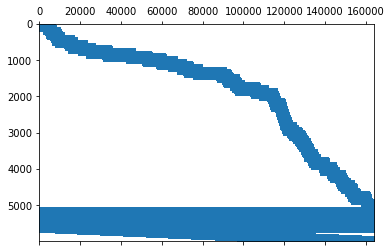

In [60]:
plt.spy(g_sum_w_totals,aspect='auto')

## Let's experiment!

In [16]:
from scripts import support, metrics, vectorization as v, aggregation
def experiment(tables_kind, method_name, bench_matrix, origin_matrix, target_matrix, experiment_type, sparsed = True, save = True, totals = False):
    """
    Получение результата эксперимента

    Parameters
    ----------
    tables_kind: string
        степень аггрегации таблиц
    method_name: string
        метод для получения новой матрицы
    bench_matrix: np.array или sparse матрица
        бенчмарк таблица
    origin_matrix: np.array или sparse матрица
        оригинальная таблица
    target_matrix: np.array или sparse матрица
        целевая таблица
    experiment_type: string
        агрегация\дезаггрегация\проекция
    sparse: bool
        использовать sparse матрицу или np.array
    Returns
    -------
    a: float
        значение метрики
    """
    if experiment_type == 'дезаггрегация':
        if tables_kind == 'sum':
            g = aggregation.keys_to_g(left_sum, right_sum)
        elif tables_kind == 'sect':
            g = aggregation.keys_to_g(left_sect, right_sect)
        else:
            raise Exception("Wrong tables_kind", tables_kind)
    elif experiment_type == 'проекция':
        ttls = v.addrows((405,405))
        g = v.addcolumns((405,405), ttls)
    else:
        raise Exception("Wrong experiment_type",experiment_type)  
    

    if sparsed:
        g = csr_matrix(g)
        
    if totals:
        g_w_totals = v.addrows((405,405), g, sparsed=sparsed)
        g_w_totals = v.addcolumns((405,405), g_w_totals, sparsed=sparsed)
    
    # For Kuroda
    if len(method_name.split('_')) > 1:
        
        method, mtype = method_name.split('_')
        method = eval(method)
        results = np.round(method(g, eval(bench_matrix), eval(origin_matrix), mtype=int(mtype), sparsed=sparsed))
    else:
        method = eval(method_name)
        results = method(g, eval(bench_matrix), eval(origin_matrix), sparsed=sparsed)
    metrics_values = metrics.get_values(np.round(results), eval(target_matrix), save=True)
    
    # Save metrics' results
    if save:
        info = {'method':method_name, 'experiment_type':experiment_type, 'target_matrix':target_matrix, 
                'origin_matrix':origin_matrix, 'bench_matrix':bench_matrix}
        info = {**info,**metrics_values}

        res_table = pd.read_excel('results/results.xlsx')
        res_table = res_table.append([info])
        res_table.to_excel('results/results.xlsx', index=None,encoding='utf-8')

    return metrics_values 

def experiments(tables_kind, bench_matrix, origin_matrix, target_matrix, experiment_type, totals = False):
    methods_list = ['nras','insd','kuroda_3','kuroda_2','kuroda_1']
    sparsed = True
    for i, method in enumerate(methods_list):
        print('Method:', method)
        if i > 2:
            sparsed = False
        experiment(tables_kind, method, bench_matrix, origin_matrix, target_matrix, experiment_type, 
                   sparsed = sparsed, totals = totals)
            

In [40]:
#Эксперимент: проекция таблицы DET_2012 из таблицы totals_2012
#Бенчмарк: DET_2007
#Ограничения: таблица totals_2012
#Методы: NRAS, точность 0.01, 100 иттераций, INSD, Kuroda(1,2,3)

experiments('', 'det_2007', 'totals_2012', 'det_2012', 'проекция')

Method: nras
67
Method: insd
Parameter BarConvTol unchanged
   Value: 1e-08  Min: 0.0  Max: 1.0  Default: 1e-08
Parameter BarQCPConvTol unchanged
   Value: 1e-06  Min: 0.0  Max: 1.0  Default: 1e-06
Changed value of parameter DualReductions to 0
   Prev: 1  Min: 0  Max: 1  Default: 1
Method: kuroda_3
Parameter BarConvTol unchanged
   Value: 1e-08  Min: 0.0  Max: 1.0  Default: 1e-08
Parameter BarQCPConvTol unchanged
   Value: 1e-06  Min: 0.0  Max: 1.0  Default: 1e-06
Parameter DualReductions unchanged
   Value: 1  Min: 0  Max: 1  Default: 1
Method: kuroda_2
Parameter BarConvTol unchanged
   Value: 1e-08  Min: 0.0  Max: 1.0  Default: 1e-08
Parameter BarQCPConvTol unchanged
   Value: 1e-06  Min: 0.0  Max: 1.0  Default: 1e-06
Parameter DualReductions unchanged
   Value: 1  Min: 0  Max: 1  Default: 1
Method: kuroda_1
Parameter BarConvTol unchanged
   Value: 1e-08  Min: 0.0  Max: 1.0  Default: 1e-08
Parameter BarQCPConvTol unchanged
   Value: 1e-06  Min: 0.0  Max: 1.0  Default: 1e-06
Paramete

In [56]:
#Эксперимент: проекция таблицы DET_2007 из таблицы totals_2007
#Бенчмарк: DET_2012
#Ограничения: таблица totals_2007
#Методы: NRAS, точность 0.01, 100 иттераций, INSD, Kuroda(1,2,3)

experiments('', 'det_2012', 'totals_2007', 'det_2007', 'проекция')

Method: nras
78
Method: insd
Parameter BarConvTol unchanged
   Value: 1e-08  Min: 0.0  Max: 1.0  Default: 1e-08
Parameter BarQCPConvTol unchanged
   Value: 1e-06  Min: 0.0  Max: 1.0  Default: 1e-06
Changed value of parameter DualReductions to 0
   Prev: 1  Min: 0  Max: 1  Default: 1
Method: kuroda_3
Parameter BarConvTol unchanged
   Value: 1e-08  Min: 0.0  Max: 1.0  Default: 1e-08
Parameter BarQCPConvTol unchanged
   Value: 1e-06  Min: 0.0  Max: 1.0  Default: 1e-06
Parameter DualReductions unchanged
   Value: 1  Min: 0  Max: 1  Default: 1
Method: kuroda_2
Parameter BarConvTol unchanged
   Value: 1e-08  Min: 0.0  Max: 1.0  Default: 1e-08
Parameter BarQCPConvTol unchanged
   Value: 1e-06  Min: 0.0  Max: 1.0  Default: 1e-06
Parameter DualReductions unchanged
   Value: 1  Min: 0  Max: 1  Default: 1
Method: kuroda_1
Parameter BarConvTol unchanged
   Value: 1e-08  Min: 0.0  Max: 1.0  Default: 1e-08
Parameter BarQCPConvTol unchanged
   Value: 1e-06  Min: 0.0  Max: 1.0  Default: 1e-06
Paramete

In [15]:
experiment('sum', 'nras', 'det_2007', 'true_sum_2012', 'det_2012', 'дезаггрегация', True)

1


{'N0': 1481,
 'PSISTAT': 0.0338,
 'RSQ': 0.9684,
 'MAPE': 14.9614,
 'SWAD': 0.066,
 'WAPE': 23.2184}

In [16]:
experiment('sum', 'insd', 'det_2007', 'true_sum_2012', 'det_2012', 'дезаггрегация', True)

Academic license - for non-commercial use only
Parameter BarConvTol unchanged
   Value: 1e-08  Min: 0.0  Max: 1.0  Default: 1e-08
Parameter BarQCPConvTol unchanged
   Value: 1e-06  Min: 0.0  Max: 1.0  Default: 1e-06
Changed value of parameter DualReductions to 0
   Prev: 1  Min: 0  Max: 1  Default: 1


{'N0': 1443,
 'PSISTAT': 0.0338,
 'RSQ': 0.9684,
 'MAPE': 14.9658,
 'SWAD': 0.066,
 'WAPE': 23.2178}

In [17]:
experiment('sum', 'kuroda_3', 'det_2007', 'true_sum_2012', 'det_2012', 'дезаггрегация', sparsed = True)

Parameter BarConvTol unchanged
   Value: 1e-08  Min: 0.0  Max: 1.0  Default: 1e-08
Parameter BarQCPConvTol unchanged
   Value: 1e-06  Min: 0.0  Max: 1.0  Default: 1e-06
Parameter DualReductions unchanged
   Value: 1  Min: 0  Max: 1  Default: 1


{'N0': 1873,
 'PSISTAT': 0.0339,
 'RSQ': 0.9684,
 'MAPE': 15.0596,
 'SWAD': 0.066,
 'WAPE': 23.2343}

In [23]:
experiment('sum', 'kuroda_2', 'det_2007', 'true_sum_2012', 'det_2012', 'дезаггрегация', sparsed = False)

Parameter BarConvTol unchanged
   Value: 1e-08  Min: 0.0  Max: 1.0  Default: 1e-08
Parameter BarQCPConvTol unchanged
   Value: 1e-06  Min: 0.0  Max: 1.0  Default: 1e-06
Parameter DualReductions unchanged
   Value: 1  Min: 0  Max: 1  Default: 1


{'MAPE': 14.9874,
 'N0': 1453,
 'PSISTAT': 0.0338,
 'RSQ': 0.9684,
 'SWAD': 0.066,
 'WAPE': 23.2234}

In [19]:
experiment('sum', 'kuroda_1', 'det_2007', 'true_sum_2012', 'det_2012', 'дезаггрегация', sparsed = False)

Parameter BarConvTol unchanged
   Value: 1e-08  Min: 0.0  Max: 1.0  Default: 1e-08
Parameter BarQCPConvTol unchanged
   Value: 1e-06  Min: 0.0  Max: 1.0  Default: 1e-06
Parameter DualReductions unchanged
   Value: 1  Min: 0  Max: 1  Default: 1


{'N0': 1436,
 'PSISTAT': 0.0338,
 'RSQ': 0.9684,
 'MAPE': 14.9839,
 'SWAD': 0.066,
 'WAPE': 23.2231}

In [20]:
experiment('sect', 'nras', 'det_2007', 'true_sect_2012', 'det_2012', 'дезаггрегация', True)

1


{'N0': 1536,
 'PSISTAT': 0.0554,
 'RSQ': 0.9515,
 'MAPE': 19.3193,
 'SWAD': 0.1161,
 'WAPE': 32.4386}

In [21]:
experiment('sect', 'insd', 'det_2007', 'true_sect_2012', 'det_2012', 'дезаггрегация', True)

Parameter BarConvTol unchanged
   Value: 1e-08  Min: 0.0  Max: 1.0  Default: 1e-08
Parameter BarQCPConvTol unchanged
   Value: 1e-06  Min: 0.0  Max: 1.0  Default: 1e-06
Changed value of parameter DualReductions to 0
   Prev: 1  Min: 0  Max: 1  Default: 1


{'N0': 1508,
 'PSISTAT': 0.0554,
 'RSQ': 0.9515,
 'MAPE': 19.3278,
 'SWAD': 0.1161,
 'WAPE': 32.4389}

In [22]:
experiment('sect', 'kuroda_3', 'det_2007', 'true_sect_2012', 'det_2012', 'дезаггрегация', sparsed = True)

Parameter BarConvTol unchanged
   Value: 1e-08  Min: 0.0  Max: 1.0  Default: 1e-08
Parameter BarQCPConvTol unchanged
   Value: 1e-06  Min: 0.0  Max: 1.0  Default: 1e-06
Parameter DualReductions unchanged
   Value: 1  Min: 0  Max: 1  Default: 1


{'N0': 7766,
 'PSISTAT': 0.0597,
 'RSQ': 0.9482,
 'MAPE': 21.3856,
 'SWAD': 0.1161,
 'WAPE': 32.9823}

In [23]:
experiment('sect', 'kuroda_2', 'det_2007', 'true_sect_2012', 'det_2012', 'дезаггрегация', sparsed = False)

Parameter BarConvTol unchanged
   Value: 1e-08  Min: 0.0  Max: 1.0  Default: 1e-08
Parameter BarQCPConvTol unchanged
   Value: 1e-06  Min: 0.0  Max: 1.0  Default: 1e-06
Parameter DualReductions unchanged
   Value: 1  Min: 0  Max: 1  Default: 1


{'N0': 1509,
 'PSISTAT': 0.0554,
 'RSQ': 0.9515,
 'MAPE': 19.352,
 'SWAD': 0.1161,
 'WAPE': 32.4562}

In [24]:
experiment('sect', 'kuroda_1', 'det_2007', 'true_sect_2012', 'det_2012', 'дезаггрегация', sparsed = False)

Parameter BarConvTol unchanged
   Value: 1e-08  Min: 0.0  Max: 1.0  Default: 1e-08
Parameter BarQCPConvTol unchanged
   Value: 1e-06  Min: 0.0  Max: 1.0  Default: 1e-06
Parameter DualReductions unchanged
   Value: 1  Min: 0  Max: 1  Default: 1


{'N0': 1509,
 'PSISTAT': 0.0554,
 'RSQ': 0.9515,
 'MAPE': 19.352,
 'SWAD': 0.1161,
 'WAPE': 32.4562}

In [9]:


ttls = v.addrows((405,405))
ttls = v.addcolumns((405,405), ttls)
tst = kuroda(ttls, det_2007, totals_2012, 1)
metrics.get_values(tst, det_2012)

Academic license - for non-commercial use only
Parameter BarConvTol unchanged
   Value: 1e-08  Min: 0.0  Max: 1.0  Default: 1e-08
Parameter BarQCPConvTol unchanged
   Value: 1e-06  Min: 0.0  Max: 1.0  Default: 1e-06
Parameter DualReductions unchanged
   Value: 1  Min: 0  Max: 1  Default: 1
N0 1511
PSISTAT 0.0428
RSQ 0.9501
MAPE 13.618
SWAD 0.1043
WAPE 26.6881
